In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, r2_score
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# Cargar CSV en un DataFrame
df = pd.read_csv("processed_data/athlete_events_clean_final.csv")

In [3]:
df

,ID,Sex,Age,Height,Weight,Team,Games,City,Sport,Medal,Medal_num,Medal_bin
0,1,M,24.0,180.0,80.0,China,1992 Summer,Barcelona,Basketball,No medal,0,0
1,2,M,23.0,170.0,60.0,China,2012 Summer,London,Judo,No medal,0,0
2,5,F,21.0,185.0,82.0,Netherlands,1988 Winter,Calgary,Speed Skating,No medal,0,0
3,5,F,21.0,185.0,82.0,Netherlands,1988 Winter,Calgary,Speed Skating,No medal,0,0
4,5,F,25.0,185.0,82.0,Netherlands,1992 Winter,Albertville,Speed Skating,No medal,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
178350,135569,M,29.0,179.0,89.0,Poland,1976 Winter,Innsbruck,Luge,No medal,0,0
178351,135570,M,27.0,176.0,59.0,Poland,2014 Winter,Sochi,Ski Jumping,No medal,0,0
178352,135570,M,27.0,176.0,59.0,Poland,2014 Winter,Sochi,Ski Jumping,No medal,0,0
178353,135571,M,30.0,185.0,96.0,Poland,1998 Winter,Nagano,Bobsleigh,No medal,0,0


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Height'}>],
       [<Axes: title={'center': 'Weight'}>, <Axes: >]], dtype=object)

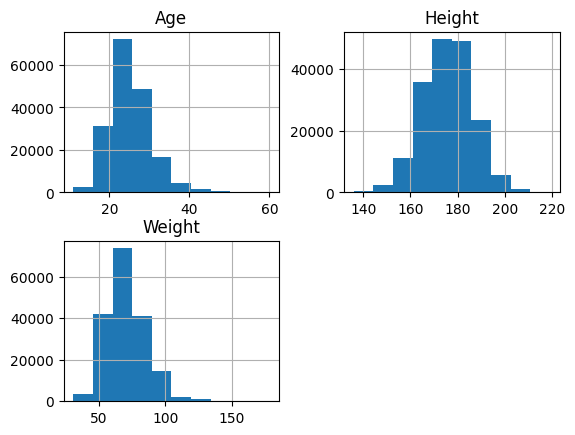

In [4]:
df[["Age","Height","Weight"]].hist()

#Las tres varaibles parece que tienen una distribución Gaussiana, por lo que no haremos el log.

In [5]:
#Vamos a hacer un modelo de Base antes de hacer el CV, en el modelo de base tenemos que aplicar tecnicas de balanceo. Como nuestras variables
#categoricas son muy grandes, el one hot encoder nos generaria muchisimas columnas. Para este tipo de columnas, aplicamos TargetEncoder.

#En principio vamos a quedarnos con medal_num como target. 
# Si vemos que no somos capaces de predecir correctamente el metal de la medalla, pasaremos a el target binario (Medalla/No medalla)

X = df.drop(['Medal', 'Medal_num','Medal_bin'], axis=1)
y = df['Medal_num']

cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
num_cols1 = ["Age","Height","Weight"]

In [ ]:
#dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Guardar train y test en CSV
train_set = X_train.copy()
train_set['Medal_num'] = y_train
train_set.to_csv('train/train_set.csv', index=False)

test_set = X_test.copy()
test_set['Medal_num'] = y_test
test_set.to_csv('test/test_set.csv', index=False)

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(142684, 9)
(35671, 9)
(142684,)
(35671,)


In [8]:
#Creamos la matriz de correlación y para ello hacemos un preprocesamiento de datos para convertir variables categoricas con TargetEncoder

corr_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", TargetEncoder(), cat_cols),
        ("num", StandardScaler(), num_cols)
    ],
    remainder='drop'
)

corr_preprocessor.fit(X_train, y_train)
X_train_corr = corr_preprocessor.transform(X_train)

df_corr = pd.DataFrame(
    X_train_corr,
    columns=list(cat_cols) + list(num_cols)
)
df_corr["Medal_num"] = y_train.values

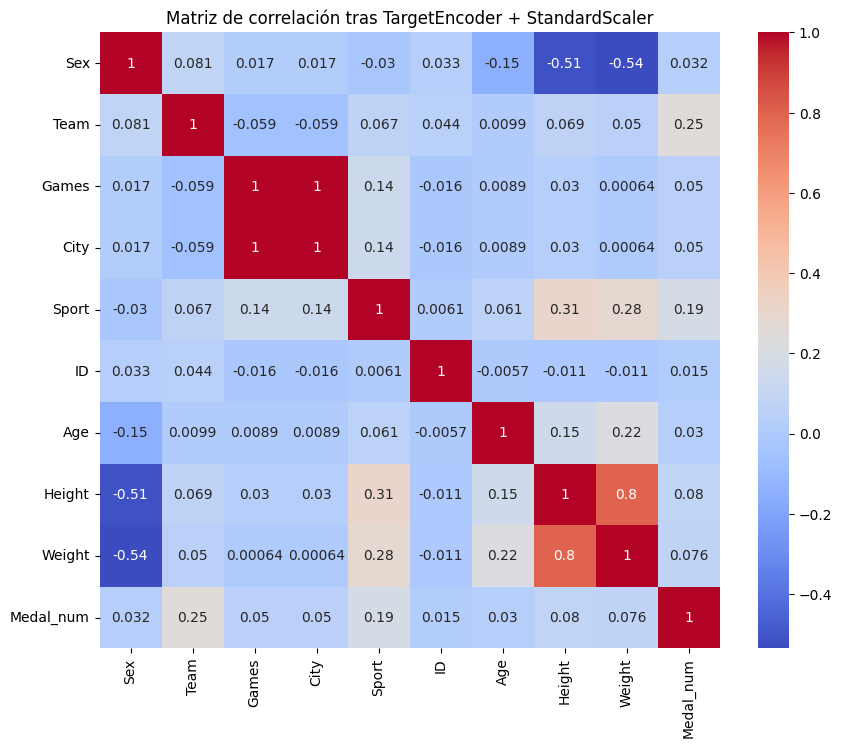

In [9]:
corr = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación tras TargetEncoder + StandardScaler")
plt.show()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", TargetEncoder(), cat_cols),
        ("num", StandardScaler(), num_cols), #Escalamos por defecto porque en el futuro vamos a probar varios modelos, pero en este caso para arboles no seria necesario.
    ],
    remainder='drop'
)

In [25]:
#Como usamos la tecnica de SMOTE despues del preprocessor, necesitamos el modulo ImbPipeline ya que el Pipeline no trata bien el SMOTE.

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=6,
        min_samples_leaf = 10,
        class_weight="balanced",  #para que ponga cariño a las clases minoritarias
        random_state=42,
        n_jobs=-1
    ))
])

In [26]:
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [33]:
y_pred_train = pipeline.predict(X_train)

y_proba_train = pipeline.predict_proba(X_train)


In [ ]:
# Métricas de evaluación train con SMOTE
accuracy = round(accuracy_score(y_train, y_pred_train),2)
f1 = round(f1_score(y_train, y_pred_train, average='weighted'),2)
precision = round(precision_score(y_train, y_pred_train, average='weighted'),2)
recall = round(recall_score(y_train, y_pred_train, average='weighted'),2)
conf_matrix = confusion_matrix(y_train, y_pred_train)


print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Matriz de Confusión:\n", conf_matrix)
print("\nReporte de clasificación:\n", classification_report(y_train, y_pred_train))
print("\nMatriz de probabilidad:\n",y_proba_train)


#Accuracy: 0.66 → bastante baja para un dataset de train. Esto indica que el modelo tien dificultades para clasificar correctamente, a pesar de que SMOTE ha aumentado las clases minoritarias.
#F1 Score: 0.72 → mejor que la accuracy, lo que refleja que el modelo tiene un balance entre precision y recall decente en algunas clases, pero no en todas.
#Precision: 0.81 → cuando predice una clase, lo hace bastante bien a priori, pero si miramos la precisión por clase, vemos que acierta mayoritariamente en la clase 'Sin Medalla'.
#Recall: 0.66 → el modelo falla en detectar muchos casos reales, especialmente en las clases minoritarias.
#Interpretación: SMOTE ha generado muestras a partir de nuestros puntos, pero la clase mayoritaria todavía domina, haciendo que el modelo prediga mucho la clase 0 y tenga bajo recall en las minoritarias.

#Vemos tambien que en la matriz de probabilidad, los porcentajes estan muy repartido y la asignación no es nada clara.

#Los resultados son igual o peor en test, por lo que no los dejamos en el script.

Accuracy: 0.66
F1 Score: 0.72
Precision: 0.81
Recall: 0.66
Matriz de Confusión:
 [[88764 16724  6455 11270]
 [ 2910  1296   714  1745]
 [ 2578  1134   905  1752]
 [ 2209   883   825  2520]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.92      0.72      0.81    123213
           1       0.06      0.19      0.10      6665
           2       0.10      0.14      0.12      6369
           3       0.15      0.39      0.21      6437

    accuracy                           0.66    142684
   macro avg       0.31      0.36      0.31    142684
weighted avg       0.81      0.66      0.72    142684


Matriz de probabilidad:
 [[0.3208392  0.25600336 0.23670263 0.18645481]
 [0.16830325 0.25342672 0.26760587 0.31066416]
 [0.63694288 0.1391567  0.11658165 0.10731876]
 ...
 [0.1528661  0.28031199 0.27785151 0.28897039]
 [0.12750776 0.27413536 0.29883187 0.29952501]
 [0.19529401 0.21615887 0.23931537 0.34923175]]


In [ ]:
#Parece que dada nuestra gran cantidad de datos para nos no medallistas, 
# las tecnicas habituales de SMOTE no son suficientes y vamos a intentar comparar con un SMOTE avanzado.

pipeline_1 = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTETomek(random_state=42)), #Aqui remplazamos Smote por SmoteTomek
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=6,
        min_samples_leaf = 10,
        class_weight="balanced",  #para que ponga cariño a las clases minoritarias
        random_state=42,
        n_jobs=-1
    ))
])



In [45]:
pipeline_1.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [46]:
y_pred_train_balanced = pipeline_1.predict(X_train)

y_proba_train_balanced = pipeline_1.predict_proba(X_train)

In [ ]:
# Métricas de evaluación train utilizando SMOTETomek
accuracy = round(accuracy_score(y_train, y_pred_train_balanced),2)
f1 = round(f1_score(y_train, y_pred_train_balanced, average='weighted'),2)
precision = round(precision_score(y_train, y_pred_train_balanced, average='weighted'),2)
recall = round(recall_score(y_train, y_pred_train_balanced, average='weighted'),2)
conf_matrix = confusion_matrix(y_train, y_pred_train_balanced)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Matriz de Confusión:\n", conf_matrix)
print("\nReporte de clasificación:\n", classification_report(y_train, y_pred_train_balanced))
print("\nMatriz de probabilidad:\n",y_proba_train_balanced)

#Accuracy: 0.65 → bastante baja, similar a SMOTE estándar en train (0.66).
#F1 Score: 0.72 → idéntico a SMOTE estándar.
#Precision: 0.81 → consistente con SMOTE estándar.
#Recall: 0.65 → igual que en SMOTE estándar.
#Matriz de confusion →
# Clase 0: sigue acumulando la mayoría de predicciones.
#Clases 1,2,3: la mayoría de sus ejemplos son clasificados incorrectamente como 0 → muchas confusiones hacia la clase mayoritaria.
#Interpretación: SMOTETomek no ha cambiado significativamente las métricas globales en train respecto a SMOTE. Esto indica que la combinación de oversampling + limpieza de ejemplos frontera (Tomek links) tiene un efecto muy similar en los datos de entrenamiento.

Accuracy: 0.65
F1 Score: 0.72
Precision: 0.81
Recall: 0.65
Matriz de Confusión:
 [[88325 16604  6930 11354]
 [ 2910  1226   787  1742]
 [ 2567  1109   949  1744]
 [ 2193   880   836  2528]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.92      0.72      0.81    123213
           1       0.06      0.18      0.09      6665
           2       0.10      0.15      0.12      6369
           3       0.15      0.39      0.21      6437

    accuracy                           0.65    142684
   macro avg       0.31      0.36      0.31    142684
weighted avg       0.81      0.65      0.72    142684


Matriz de probabilidad:
 [[0.31142563 0.25914939 0.24006492 0.18936006]
 [0.16892932 0.25484034 0.26637373 0.3098566 ]
 [0.64092288 0.13738407 0.11513017 0.10656289]
 ...
 [0.15053629 0.28020821 0.27938905 0.28986645]
 [0.12497786 0.2760949  0.29982596 0.29910129]
 [0.19680797 0.21674596 0.23875297 0.34769309]]


In [57]:
#Vemos que sigue existiendo un gran desbalanceo a pesar de nuestras tecnicas. Con un recal medio bastante bajo.
#Vamos a implementar tecnicas de undersampling a ver que tal

pipeline_2 = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersample', RandomUnderSampler(random_state=42) ),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

In [58]:
pipeline_2.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('undersample', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [59]:
y_pred_train_balanced_under = pipeline_2.predict(X_train)

y_proba_train_balanced_under = pipeline_2.predict_proba(X_train)

In [ ]:
# Métricas de evaluación train utilizando UnderSampling
accuracy = round(accuracy_score(y_train, y_pred_train_balanced_under),2)
f1 = round(f1_score(y_train, y_pred_train_balanced_under, average='weighted'),2)
precision = round(precision_score(y_train, y_pred_train_balanced_under, average='weighted'),2)
recall = round(recall_score(y_train, y_pred_train_balanced_under, average='weighted'),2)
conf_matrix = confusion_matrix(y_train, y_pred_train_balanced_under)
r2 = round(r2_score(y_train, y_pred_train_balanced_under),2)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Matriz de Confusión:\n", conf_matrix)
print("\nReporte de clasificación:\n", classification_report(y_train, y_pred_train_balanced_under))
print("\nMatriz de probabilidad:\n",y_proba_train_balanced_under)

#Accuracy: 0.67 → ligeramente superior a SMOTE/SMOTETomek (0.65–0.66).
#F1 Score: 0.73 → también un poco mejor que los métodos de oversampling.
#Precision: 0.90 → notablemente más alta, sobre todo porque el modelo predice menos falsos positivos para la clase mayoritaria.
#Recall: 0.67 → similar a SMOTE, aunque con la ventaja de mejorar F1 por la combinación de mayor precision.
#Interpretación: El modelo mantiene un buen balance entre precision y recall globales. El undersampling hace que la clase mayoritaria pierda fuerza relativa, lo que ayuda a mejorar las métricas de las minoritarias.
#Matriz de confusión → 
#Clase 0: más errores → confusión hacia las minoritarias (18817, 15751, 11231).
#Clases 1,2,3: errores mínimos, la mayoría de los ejemplos se clasifican correctamente → confirma recall alto.
#Interpretación: la clase mayoritaria pierde recall, pero las minoritarias mejoran mucho.
#Sin embargo, aún estamos lejos de la optimización. 

Accuracy: 0.67
F1 Score: 0.73
Precision: 0.9
Recall: 0.67
Matriz de Confusión:
 [[77414 18817 15751 11231]
 [  123  6165   170   207]
 [   56   125  5976   212]
 [   41   127   186  6083]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      0.63      0.77    123213
           1       0.24      0.92      0.39      6665
           2       0.27      0.94      0.42      6369
           3       0.34      0.95      0.50      6437

    accuracy                           0.67    142684
   macro avg       0.46      0.86      0.52    142684
weighted avg       0.90      0.67      0.73    142684


Matriz de probabilidad:
 [[0.71666667 0.16672222 0.08883333 0.02777778]
 [0.38944444 0.32153175 0.18668254 0.10234127]
 [0.63666667 0.11833333 0.16041667 0.08458333]
 ...
 [0.16666667 0.27666667 0.33933333 0.21733333]
 [0.17809524 0.40038889 0.25597619 0.16553968]
 [0.41833333 0.20661111 0.20416667 0.17088889]]


In [69]:
#Por último, vamos a intentar hacer una combinación de Undersampling y Smote a ver si mejoramos aÚn mas. 

from collections import Counter
counter = Counter(y_train)
n_major = counter[0]

# Definimos proporciones
smote = SMOTE(sampling_strategy={
    1: int(n_major*0.5),
    2: int(n_major*0.5),
    3: int(n_major*0.5)
}, random_state=42)


pipeline_3 = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote), 
    ('undersample', RandomUnderSampler(sampling_strategy={0: int(n_major*0.8)}, random_state=42)),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

In [70]:
pipeline_3.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [71]:
y_pred_train_mix_balanced = pipeline_3.predict(X_train)

y_proba_train_mix_balanced = pipeline_3.predict_proba(X_train)

In [ ]:
# Métricas de evaluación train utilizando UnderSampling + SMOTE
accuracy = round(accuracy_score(y_train, y_pred_train_mix_balanced),2)
f1 = round(f1_score(y_train, y_pred_train_mix_balanced, average='weighted'),2)
precision = round(precision_score(y_train, y_pred_train_mix_balanced, average='weighted'),2)
recall = round(recall_score(y_train, y_pred_train_mix_balanced, average='weighted'),2)
conf_matrix = confusion_matrix(y_train, y_pred_train_mix_balanced)
r2 = round(r2_score(y_train, y_pred_train_mix_balanced),2)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Matriz de Confusión:\n", conf_matrix)
print("\nReporte de clasificación:\n", classification_report(y_train, y_pred_train_mix_balanced))
print("\nMatriz de probabilidad:\n",y_proba_train_mix_balanced)

#Accuracy: 0.96 → muy superior a cualquier método individual (SMOTE ~0.66, Undersampling ~0.67).
#F1 Score: 0.96 → indica un muy buen balance entre precision y recall para todas las clases.
#Precision: 0.96 → alta precisión global.
#Recall: 0.96 → el modelo captura correctamente la mayoría de las instancias, incluso de clases minoritarias.

#Interpretación: La combinación SMOTE + Undersampling logra un balance óptimo entre clases, evitando los problemas de SMOTE solo (clase mayoritaria domina) o undersampling solo (pérdida de información de clase 0).
#La combinación logra que todas las clases sean reconocidas de manera eficiente, sin sacrificar recall de la clase mayoritaria.

#En la matriz de confusion vemos que:
#Clase 0: muy pocos errores (998 + 1037 + 946) → indica que la clase mayoritaria sigue siendo reconocida correctamente.
#Clases 1-3: errores mínimos, mayoría de instancias correctamente clasificadas → recall alto.

#La matriz confirma que los problemas usando métodos individuales desaparecen; tanto la clase mayoritaria como las minoritarias son bien reconocidas.

Accuracy: 0.96
F1 Score: 0.96
Precision: 0.96
Recall: 0.96
Matriz de Confusión:
 [[120232    998   1037    946]
 [   640   5746    130    149]
 [   514    107   5542    206]
 [   373    114    155   5795]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98    123213
           1       0.82      0.86      0.84      6665
           2       0.81      0.87      0.84      6369
           3       0.82      0.90      0.86      6437

    accuracy                           0.96    142684
   macro avg       0.86      0.90      0.88    142684
weighted avg       0.96      0.96      0.96    142684


Matriz de probabilidad:
 [[0.93840103 0.02621435 0.03205129 0.00333333]
 [0.99666667 0.         0.         0.00333333]
 [1.         0.         0.         0.        ]
 ...
 [0.7920757  0.0479243  0.11       0.05      ]
 [0.87333333 0.03666667 0.04833333 0.04166667]
 [0.88       0.04903704 0.03       0.04096296]]


In [73]:
y_pred_test_mix_balanced = pipeline_3.predict(X_test)

y_proba_test_mix_balanced = pipeline_3.predict_proba(X_test)

In [ ]:
# Métricas de evaluación test utilizando UnderSampling + SMOTE
accuracy = round(accuracy_score(y_test, y_pred_test_mix_balanced),2)
f1 = round(f1_score(y_test, y_pred_test_mix_balanced, average='weighted'),2)
precision = round(precision_score(y_test, y_pred_test_mix_balanced, average='weighted'),2)
recall = round(recall_score(y_test, y_pred_test_mix_balanced, average='weighted'),2)
conf_matrix = confusion_matrix(y_test, y_pred_test_mix_balanced)
r2 = round(r2_score(y_test, y_pred_test_mix_balanced),2)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Matriz de Confusión:\n", conf_matrix)
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_test_mix_balanced))
print("\nMatriz de probabilidad:\n",y_proba_test_mix_balanced)

#Accuracy: 0.86 → significativamente menor que el train (0.96), pero razonable considerando que el dataset es muy desbalanceado.
#F1 Score: 0.85 → cae respecto al train (0.96), lo que indica overfitting parcial: el modelo se ajustó muy bien al train balanceado, pero minoritarias del test siguen difíciles de predecir.
#Precision: 0.84 → aceptable, pero menor que train (0.96).
#Recall: 0.86 → también menor que en train (0.96), indica que aún se pierden algunas instancias, especialmente de clases minoritarias.

#Interpretación: El modelo tiene buen rendimiento en general, pero el test refleja la dificultad real de predecir clases minoritarias fuera del train artificialmente balanceado.

#Clase 0 (mayoritaria): sigue muy bien reconocida (recall 0.95), aunque menor que train (0.98).
#Clases minoritarias: caída importante en recall y F1 (0.24–0.37), lo que indica que el modelo aún confunde muchas instancias minoritarias con la clase mayoritaria.

#Las minoritarias siguen siendo difíciles de predecir correctamente, aun habiendo balanceado train.

#Interpretación: El test refleja la realidad desbalanceada del dataset original: SMOTE + Undersampling mejora la situación en train, pero no elimina la dificultad de las minoritarias en datos reales.

#Matriz de confusion
# Clase 0: 29410 de 30803 correctamente → 1393 errores (mayoría de ellos hacia otras clases minoritarias).
#Clases minoritarias: muchos falsos negativos → modelo predice mayoritaria 0 con frecuencia.

#Matriz de probabilidades
#Para la clase 0: muchas probabilidades altas (0.7–0.99) → modelo muy seguro.
#Para minoritarias: probabilidades bajas y dispersas → el modelo tiene baja confianza en las clases 1–3 en test.

Accuracy: 0.86
F1 Score: 0.85
Precision: 0.84
Recall: 0.86
Matriz de Confusión:
 [[29410   462   452   479]
 [ 1050   400    89   128]
 [  954    89   394   155]
 [  793    90   133   593]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93     30803
           1       0.38      0.24      0.30      1667
           2       0.37      0.25      0.30      1592
           3       0.44      0.37      0.40      1609

    accuracy                           0.86     35671
   macro avg       0.53      0.45      0.48     35671
weighted avg       0.84      0.86      0.85     35671


Matriz de probabilidad:
 [[0.73763319 0.11906391 0.093      0.05030289]
 [1.         0.         0.         0.        ]
 [0.97333333 0.01666667 0.01       0.        ]
 ...
 [0.97711712 0.01       0.00666667 0.00621622]
 [0.95645279 0.04021387 0.00333333 0.        ]
 [0.98797672 0.00428572 0.00773756 0.        ]]


In [ ]:
#Vamos a intentar mejorar el model haciendo CrossValidation y optimizando el modelo a utilizar y los parametros. 
# Este solo sera nuestro modelo base, y nos quedaremos con el balanceo combinado de SMOTE + undersampling